## pop3_acp

### Imports

In [8]:
import pandas as pd
# google drive folder access
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# import pickle

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import decomposition
from sklearn import preprocessing
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# classe pour k-means
from sklearn.cluster import KMeans
# classe pour cah
from scipy.cluster.hierarchy import linkage, fcluster

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
# sns.set(style="white")
# sns.set_palette("GnBu_d")
sns.set_style("ticks")

### Load datas

In [9]:
# Table pop3_df_base.csv
path_df_base = "./datas/pop3_df_base.csv"
df_base = pd.read_csv(path_df_base, sep=',', error_bad_lines=False, index_col=0)

### Functions

In [17]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(6,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 50 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey", width=0.008)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='12', ha='left', va='bottom', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure    
            sns.set_style("ticks")
            sns.set_palette("RdBu", n_colors=7)
            fig = plt.figure(figsize=(6,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], marker='.', alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z):
    plt.figure(figsize=(8,4))
    plt.title('Hierarchical Clustering Dendrogram - Groupe POP3')
    plt.ylabel('distance')
    dendrogram(
        Z,
        orientation = "top",
    )
    plt.show()

### Verification datas

In [11]:
print('df_base.shape :', df_base.shape)
print("Total missing values = ", df_base.isna().sum().sum())
df_base[['tage_PS', 'revenu', 'imc', 'pain_cereales', 'fruits_legumes', 'produits_laitiers', 
         'viandes_poissons_oeufs', 'produits_sucres', 'eau', 'alcool']].describe()

df_base.shape : (2121, 15)
Total missing values =  0


,tage_PS,revenu,imc,pain_cereales,fruits_legumes,produits_laitiers,viandes_poissons_oeufs,produits_sucres,eau,alcool
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,7.871759,8.571429,25.768907,114.817111,157.652167,177.531658,57.376445,84.080052,912.271482,184.590626
std,0.770664,3.590831,4.812153,88.125929,116.004836,144.294283,48.907099,63.100138,579.819760,226.407082
min,7.000000,1.000000,15.776830,0.535714,1.010000,1.442857,0.128143,1.428572,6.696428,0.735714
25%,7.000000,6.000000,22.321428,52.540625,74.000000,89.285713,23.107144,41.321426,482.991090,102.973230
50%,8.000000,9.000000,25.050505,96.244995,140.375007,149.958043,51.785294,72.024956,815.714330,133.078422
75%,8.000000,12.000000,28.405504,152.250000,211.428570,209.748810,73.528908,108.571423,1222.499996,175.714280
max,9.000000,13.000000,50.117188,644.872680,962.928590,2007.288030,400.714290,447.674010,3896.473400,6209.856900


### ACP

In [24]:
# choix du nombre de composantes à calculer
n_comp = 10

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_base[['diplome_interv', 'revenu', 'imc', 'pain_cereales', 'fruits_legumes', 'produits_laitiers', 
                    'viandes_poissons_oeufs', 'produits_sucres', 'eau', 'alcool']]

# Utile pour définitions clusters CAH
# theme = [df_base.loc[id, "revenu"] for id in df_base.index]
info_sup = [df_base.loc[id, "tage_PS"] for id in df_base.index]

# préparation des données pour l'acp
X = data_pca.values
# names = df_base.index
names = df_base['NOIND']
# features = df_base.columns
features = ['agglo_5cl', 'sex_PS', 'tage_PS', 'diplome_interv', 'revenu', 'imc', 'fume',  
                 'pain_cereales', 'fruits_legumes', 'produits_laitiers', 'viandes_poissons_oeufs', 'produits_sucres', 'eau', 'alcool']

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# vérification moyenne
print(np.mean(X_scaled,axis=0))
# vérification écart-type
print(np.std(X_scaled,axis=0,ddof=0))

# print(X_scaled)

[ 1.18926295e-16  5.52756018e-17 -3.61803939e-16 -4.02004377e-17
  2.01002188e-17 -1.27301386e-16 -6.70007294e-18 -1.17251277e-16
 -1.23951349e-16 -1.17251277e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Choix du nombre de composantes

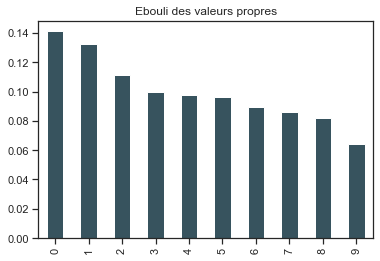

In [19]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

# Eboulis des valeurs propres
# display_scree_plot(pca)

In [20]:
ebouli

0    0.141317
1    0.132602
2    0.111316
3    0.099481
4    0.097890
5    0.096234
6    0.089255
7    0.085768
8    0.081702
9    0.064435
dtype: float64

In [21]:
# Calcul des composantes principales
n_comp_selected = 6
pca = decomposition.PCA(n_components=n_comp_selected)
principalComponents = pca.fit_transform(X_scaled)

### Cercle des corrélations - df_base

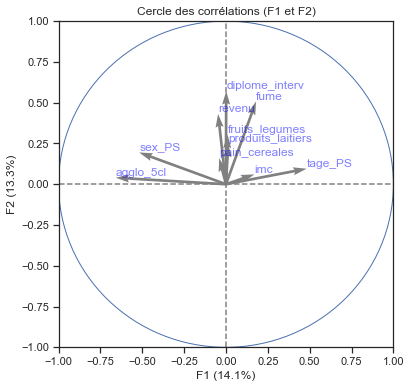

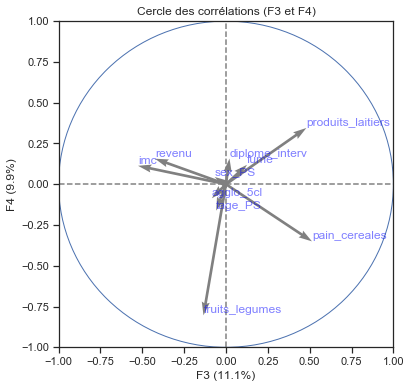

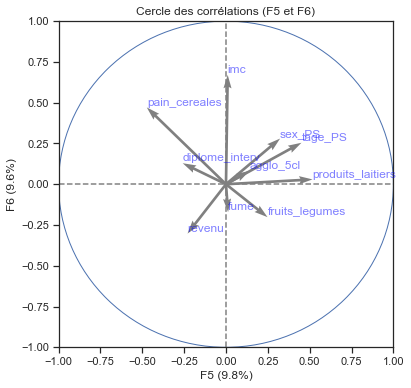

In [22]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp_selected, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

### Projection des individus - df_base

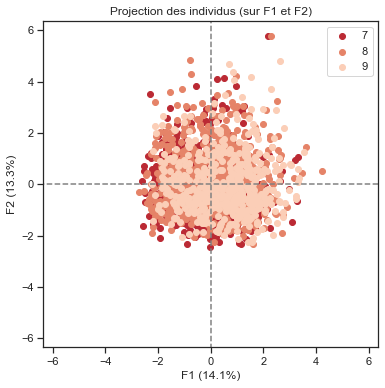

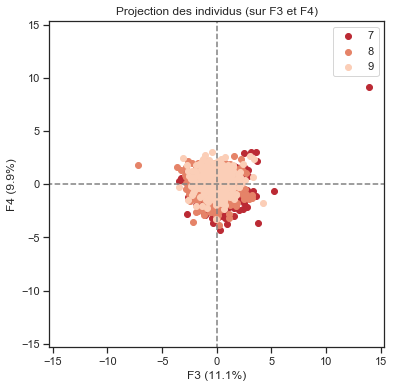

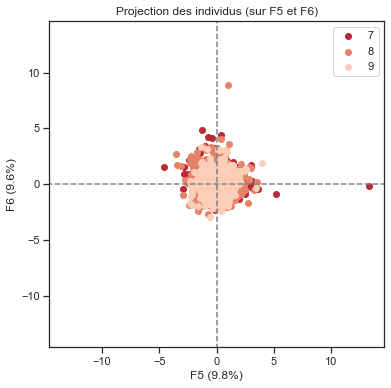

In [25]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp_selected, pca, [(0,1),(2,3),(4,5)], illustrative_var = info_sup, labels = None)

# plt.colorbar()
plt.show()

## CAH - df_base

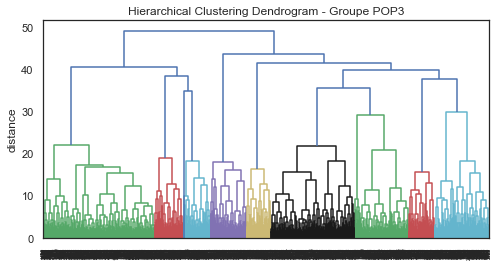

In [12]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z)

## k-means - df_base

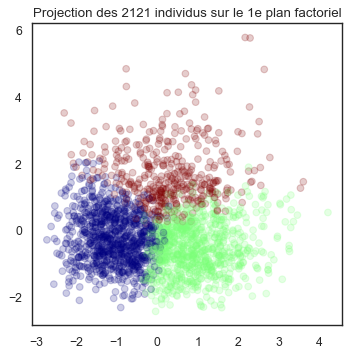

In [16]:
# Nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
data_km = data_pca

# préparation des données pour le clustering
X = data_km.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=6).fit(X_scaled)
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show(block=False)